# Clustering Companies Based on Stock Price Movements
*credit [Aslihan Demirkaya](http://github.com/AslihanDemirkaya)*

## Introduction

In this work, we will apply Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (TSNE), K-means clustering and Hierarchical clustering. We will construct our dataset using the two datasets that can be obtained here: https://www.kaggle.com/ehallmar/daily-historical-stock-prices-1970-2018. The two datasets that we use as our source, have daily stock prices for a selection of several thousand stock tickers from NYSE and NASDAQ. The dataset we will work on covers the dates between '2017-08-24' AND '2018-08-24' and the 11 industries with the most number of observations. Our aim is to cluster the records so that the companies in the same industry will be grouped together.

 

## Exploring the Dataset

As mentioned earlier, we will use two datasets as our source. Both are very large in size so we will use `data.table` to increase reading speed. The first dataset is `historical_stock_prices.csv` and the second one is `historical_stocks.csv`. The first and the second datsets have `ticker` in common. While constructing our data, we will need features from both sets. Just a note, we will use `SQL` for table manipulation.

The first dataset mostly has numerical variables as follows:

In [6]:
# ! pip install pandas
import pandas as pd

# Replace with the correct file paths in your environment
historical_stock_prices_path = "../data/historical_stock_prices.csv"
historical_stocks_path = "../data/historical_stocks.csv"

# Loading and displaying the first few rows of historical_stock_prices
historical_stock_prices = pd.read_csv(historical_stock_prices_path)

# Loading and displaying the first few rows of historical_stocks
historical_stocks = pd.read_csv(historical_stocks_path)

In [4]:
historical_stock_prices.head()

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14


The second data set has categorical data as follows: 

In [5]:
historical_stocks.head()

,ticker,exchange,name,sector,industry
0,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
1,PIHPP,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
2,TURN,NASDAQ,180 DEGREE CAPITAL CORP.,FINANCE,FINANCE/INVESTORS SERVICES
3,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES
4,FCCY,NASDAQ,1ST CONSTITUTION BANCORP (NJ),FINANCE,SAVINGS INSTITUTIONS


We need to inner join these two datasets and will select the features we need. Note that both datasets have `ticker` in common.

In [7]:
import pandas as pd

# Assuming historical_stock_prices and historical_stocks are already loaded as Pandas DataFrames
# Perform the INNER JOIN
merged_data = pd.merge(historical_stock_prices, historical_stocks, on='ticker')

# Selecting the specific columns: 'open', 'date', 'ticker' (from historical_stock_prices), and 'industry' (from historical_stocks)
stocks = merged_data[['open', 'date', 'ticker', 'industry']]

In [8]:
# Displaying the result
stocks.head()

,open,date,ticker,industry
0,11.50,2013-05-08,AHH,REAL ESTATE
1,11.66,2013-05-09,AHH,REAL ESTATE
2,11.55,2013-05-10,AHH,REAL ESTATE
3,11.63,2013-05-13,AHH,REAL ESTATE
4,11.60,2013-05-14,AHH,REAL ESTATE


Now we are interested in the observations of `stocks` that are between '2017-08-24' and '2018-08-24'. In the below code, we construct the dataset `stocks_2018`.


In [10]:
# Convert the 'date' column to datetime format for accurate comparison
stocks.loc['date'] = pd.to_datetime(stocks['date'])

# Filtering the data for dates between '2017-08-24' and '2018-08-24'
stocks_2018 = stocks[(stocks['date'] >= '2017-08-24') &
                     (stocks['date'] <= '2018-08-24')]

/var/folders/94/x3ml_gpx1fqdj4djb6rrt3640000gp/T/ipykernel_36314/2164580028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks.loc['date'] = pd.to_datetime(stocks['date'])


In [11]:
# Displaying the result
stocks_2018.head()

,open,date,ticker,industry
1083,13.4,2017-08-24,AHH,REAL ESTATE
1084,13.39,2017-08-25,AHH,REAL ESTATE
1085,13.4,2017-08-28,AHH,REAL ESTATE
1086,13.25,2017-08-29,AHH,REAL ESTATE
1087,13.21,2017-08-30,AHH,REAL ESTATE


Now, we will pick the `industry` with the highest count in `ticker`. What we mean by this is for instance there are `n` companies that belong to the industry `A`. We will pick the first 11 industries where the corresponding `n` values of these industries are the first 11 when ordered from biggest to smallest.	

Let's start this process by selecting the two features `ticker` and `industry`. Note that we want the distinct pairs. Otherwise we will count the repeated pairs with distict dates. We do not want that. That's why we will do this in two steps. 

In [13]:
# Selecting distinct combinations of 'ticker' and 'industry'
df = stocks_2018[['ticker', 'industry']].drop_duplicates()

# Displaying the result
df.head()

,ticker,industry
1083,AHH,REAL ESTATE
2948,APO,INVESTMENT MANAGERS
5898,PEZ,NaN
7048,CRCM,OTHER CONSUMER SERVICES
11069,GTN,BROADCASTING


The second step is to count the `ticker` for the corresponding industry and pick the first 12. The reason why we pick 12 but not 11 is the `N/A` values and as seen below it has the highest count.


In [15]:
# Group by 'industry' and count the occurrences
industry_counts = df.groupby('industry').size()

# Sort the counts in descending order and select the top 12, excluding the first one
top_industries = industry_counts.sort_values(ascending=False)[1:13]

# Displaying the result
top_industries

industry
MAJOR BANKS                                                      328
REAL ESTATE INVESTMENT TRUSTS                                    216
BUSINESS SERVICES                                                155
INDUSTRIAL MACHINERY/COMPONENTS                                  154
OIL & GAS PRODUCTION                                             153
COMPUTER SOFTWARE: PREPACKAGED SOFTWARE                          142
TELECOMMUNICATIONS EQUIPMENT                                     125
EDP SERVICES                                                     116
SEMICONDUCTORS                                                   104
PROPERTY-CASUALTY INSURERS                                        92
MEDICAL/DENTAL INSTRUMENTS                                        85
BIOTECHNOLOGY: BIOLOGICAL PRODUCTS (NO DIAGNOSTIC SUBSTANCES)     83
dtype: int64

After we determine our 11 industries, now we will construct the data set `stocks_11industry` that has all the obervations with the corresponding 11 industries. We do this by using the following code:

In [19]:
# Convert top_industries to a DataFrame and reset index
top_industries_df = top_industries.reset_index(name='count')

# Perform the INNER JOIN
stocks_11industry = pd.merge(
    stocks_2018, top_industries_df[['industry']], on='industry')

# Selecting the specific columns: 'open', 'date', 'ticker' (from stocks_2018), and 'industry'
stocks_11industry = stocks_11industry[['open', 'date', 'ticker', 'industry']]

# Displaying the first few rows of the result
stocks_11industry.head()

,open,date,ticker,industry
0,10.23,2017-08-24,VIAV,SEMICONDUCTORS
1,10.24,2017-08-25,VIAV,SEMICONDUCTORS
2,10.13,2017-08-28,VIAV,SEMICONDUCTORS
3,10.03,2017-08-29,VIAV,SEMICONDUCTORS
4,10.09,2017-08-30,VIAV,SEMICONDUCTORS


In the below code, we create a new variable `no`. For each `ticker`, the dates will be ordered and each date for that corresponding `ticker` will be assigned to a number. The earliest date will be assigned to 1, the next business day will be assigned to 2, and so on. Note that if there were no none business days, such as weekends, we wouldn't need that additional variable.

In [20]:
# Sorting the DataFrame first by 'ticker' and then by 'date'
stocks_11industry_sorted = stocks_11industry.sort_values(by=['ticker', 'date'])

# Adding a row number within each 'ticker' group
stocks_11industry_sorted['no'] = stocks_11industry_sorted.groupby('ticker').cumcount() + 1

# Displaying the result
stocks_11industry_sorted.head()

,open,date,ticker,industry,no
390866,66.059998,2017-08-24,AABA,EDP SERVICES,1
390867,65.410004,2017-08-25,AABA,EDP SERVICES,2
390868,64.43,2017-08-28,AABA,EDP SERVICES,3
390869,62.299999,2017-08-29,AABA,EDP SERVICES,4
390870,63.650002,2017-08-30,AABA,EDP SERVICES,5


Now, our aim is to add a new variable `open2` to our dataframe. This variable is same as `open` however, it is one business day shifted. We will use this variable `open2` and `open` to calculate the daily return. We also change the name of the variable from `open` to `open1`.

In [24]:
# Performing a self-join on added_no
added_open2 = pd.merge(
    stocks_11industry_sorted,
    stocks_11industry_sorted,
    on='ticker',
    suffixes=('', '_2')
)

# Filtering to get the rows where ar2.no is ar1.no + 1
added_open2 = added_open2[added_open2['no_2'] == added_open2['no'] + 1]

# Selecting specific columns and renaming as needed
added_open2 = added_open2[['open', 'date',
                           'ticker', 'industry', 'no', 'no_2', 'open_2']]
added_open2.rename(columns={'open': 'open1', 'open_2': 'open2'}, inplace=True)

Now let's look at our new dataframe with the new variables. 

In [23]:
# Displaying the result
added_open2.head()

,open1,date,ticker,industry,no,no_2,open2
1,66.059998,2017-08-24,AABA,EDP SERVICES,1,2,65.410004
255,65.410004,2017-08-25,AABA,EDP SERVICES,2,3,64.43
509,64.43,2017-08-28,AABA,EDP SERVICES,3,4,62.299999
763,62.299999,2017-08-29,AABA,EDP SERVICES,4,5,63.650002
1017,63.650002,2017-08-30,AABA,EDP SERVICES,5,6,64.5


Now we are going to add a new variable `daily_return` and call the new data frame as `data_daily_return`. The formula we use is as follows:

$$
\text{daily\_return}=\frac{open2}{open1}*100-100
$$

In [25]:
# Calculating daily return
added_daily_return = added_open2.copy()
added_daily_return['daily_return'] = (
    added_daily_return['open2'] / added_daily_return['open1']) * 100 - 100

# Selecting specific columns
added_daily_return = added_daily_return[[
    'date', 'ticker', 'industry', 'no', 'open1', 'open2', 'daily_return']]

Now let's look at our new data frame `data_daily_return`.

In [26]:
added_daily_return.head()

,date,ticker,industry,no,open1,open2,daily_return
1,2017-08-24,AABA,EDP SERVICES,1,66.059998,65.410004,-0.983945
255,2017-08-25,AABA,EDP SERVICES,2,65.410004,64.43,-1.498247
509,2017-08-28,AABA,EDP SERVICES,3,64.43,62.299999,-3.305915
763,2017-08-29,AABA,EDP SERVICES,4,62.299999,63.650002,2.166938
1017,2017-08-30,AABA,EDP SERVICES,5,63.650002,64.5,1.335426


### Dealing with Outliers
Before we apply our methods, we would like to deal with the outliers for the variable `daily_return`. We will not remove them, instead, we will replace these values with the upper or lower whisker values for the corresponing `ticker`. 
So let's group the data by the ticker and also the date.

In [30]:
import numpy as np

# Calculating the first and third quartiles for the entire DataFrame
Q1 = added_daily_return['daily_return'].quantile(0.25)
Q3 = added_daily_return['daily_return'].quantile(0.75)

# Calculating the interquartile range and the whiskers
IQR = Q3 - Q1
max_open1 = Q3 + (IQR * 1.5)  # Upper whisker value
min_open1 = Q1 - (IQR * 1.5)  # Lower whisker value

# Custom aggregation function for capping daily_return


def cap_values(series):
    return np.where(
        series > max_open1, max_open1,
        np.where(series < min_open1, min_open1, series)
    ).mean()


# Grouping by 'ticker' and 'date' with custom aggregation
grouped_date_ticker = added_daily_return.groupby(['ticker', 'date']).agg({
    'industry': 'first',
    'daily_return': cap_values,  # Apply the custom aggregation function
    'no': 'last'
}).reset_index()

# Displaying the result
grouped_date_ticker.head()

,ticker,date,industry,daily_return,no
0,AABA,2017-08-24,EDP SERVICES,-0.983945,1
1,AABA,2017-08-25,EDP SERVICES,-1.498247,2
2,AABA,2017-08-28,EDP SERVICES,-3.305915,3
3,AABA,2017-08-29,EDP SERVICES,2.166938,4
4,AABA,2017-08-30,EDP SERVICES,1.335426,5


Now let's look at the summary and the boxplot of `daily_return` after we worked with the outliers.

count    415551.000000
mean          0.046163
std           1.880895
min          -3.977090
25%          -0.958304
50%           0.000000
75%           1.054220
max           4.073006
Name: daily_return, dtype: float64


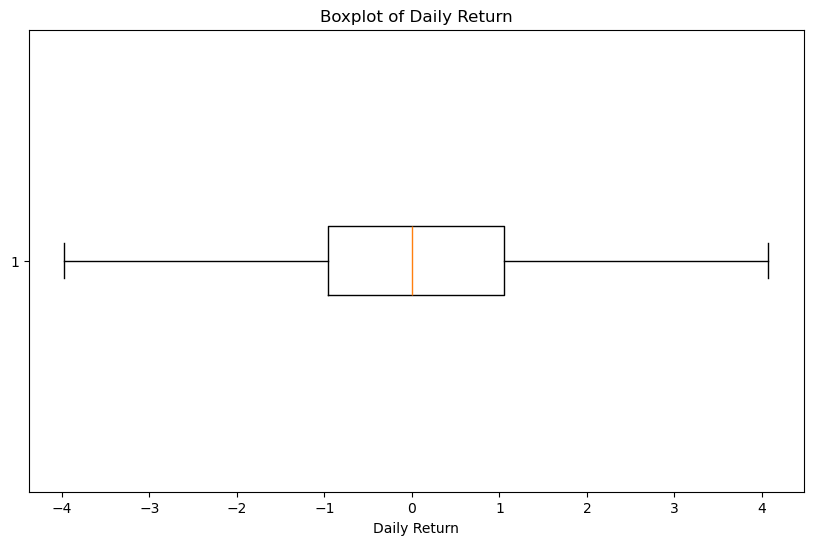

In [31]:
import matplotlib.pyplot as plt

# Summary statistics for 'daily_return'
summary_stats = grouped_date_ticker['daily_return'].describe()
print(summary_stats)

# Creating a boxplot for 'daily_return'
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_date_ticker['daily_return'], vert=False)
plt.title('Boxplot of Daily Return')
plt.xlabel('Daily Return')
plt.show()

### Changing the `date` values into features
The idea is to see the `daily_return` for each `ticker` daily. We will use `spread` function from the `tidyr` package. We have to remove the `rn` variable, otherwise we do not get what we want. You can try and see as an exercise.

In [32]:
# Dropping the 'no' column
grouped_date_ticker.drop('no', axis=1, inplace=True)

# Reshaping the data so that each date becomes a column
stocks_daily_return = grouped_date_ticker.pivot(
    index=['ticker', 'industry'], columns='date', values='daily_return')

# Replacing NaN values with 0
stocks_daily_return.fillna(0, inplace=True)

# Resetting the index to flatten the DataFrame
stocks_daily_return.reset_index(inplace=True)

# Displaying the first 6 columns of the DataFrame
stocks_daily_return.iloc[:, :6].head()

date,ticker,industry,2017-08-24 00:00:00,2017-08-25 00:00:00,2017-08-28 00:00:00,2017-08-29 00:00:00
0,AABA,EDP SERVICES,-0.983945,-1.498247,-3.305915,2.166938
1,AAOI,SEMICONDUCTORS,-3.719710,-0.865664,-2.926910,4.073006
2,AAON,INDUSTRIAL MACHINERY/COMPONENTS,-0.156737,0.000000,-0.156989,0.471703
3,AAT,REAL ESTATE INVESTMENT TRUSTS,0.371383,0.789343,-1.321588,-0.297616
4,AAV,OIL & GAS PRODUCTION,-0.775189,0.781246,-2.325576,0.793646


In [34]:
# Save the stocks_daily_return DataFrame as a Excel file for further analysis
stocks_daily_return.to_excel('../data/excel_data/stocks_daily_return.xlsx', index=False)

# Save the dataframe to an Excel file in the stage it was before changing the perspective of the data to a time series format in order to be able to compare the differences between the two perspectives
grouped_date_ticker.to_excel('../data/excel_data/grouped_date_ticker.xlsx', index=False)

Now, we are ready to apply our methods. We will start with PCA and then TSNE. We will compare both methods. Afterwards, we will study clustering and see if we get consistent results with K-means and hierarchial.
### Principal Component Analysis (PCA)
In this section, we are going to apply PCA. However, we should be careful with our varibles. PCA handles numerical values, not categorical ones. Also one of the requirements is scaling the dataset. However, we only have one variable to work with, that is `daliy_return` so there is no need to scale.
In the below code, we define a new data frame with only numerical features.

In [ ]:
rem_cat<-stocks_daily_return[c(-1,-2)] #we remove the categorical variables
head(rem_cat[,1:6])

Now we are ready to apply PCA to the data set `rem_cat`. Since we have 252 date features, we do not want to show the output of PCA. Instead, we only show the head of the loadings on the first 6 principal components.

In [ ]:
pca.out<-prcomp(rem_cat, scale=FALSE) 
df_out <- as.data.frame(pca.out$x)
head(df_out[,1:6])

Now let's use `biplot` to plot the PCA results where the axes are PC1 and PC2.

In [ ]:
biplot(pca.out, scale=0, cex=1.2) #cex is for the font

As seen the plot is very crowded and hard to detect the points, directions, etc. So let's try something else. For that purpose, we will use the package: `ggplot2` and for extra nicer look, we will add the packages: `grid` and `gridExtra`.

In [ ]:
library(ggplot2)
library(grid)
library(gridExtra)
p<-ggplot(df_out,aes(x=PC1,y=PC2,color=stocks_daily_return$industry ))
p<-p+geom_point()
p

From the figure, we can say that PCA did a good job in separating oil and gas production from other industries, but not with the rest of the industries.
### t-Distributed Stochastic Neighbor Embedding (TSNE) 

In [ ]:
## calling the installed package
library(Rtsne)
rem_cat$label <- stocks_daily_return$industry
rem_cat$label<-as.factor(rem_cat$label)
tsne <- Rtsne(rem_cat[,-1], dims = 2, perplexity=30, verbose=TRUE, max_iter = 1500)

As we did for the PCA, let's see the head of the two vectors of TSNE.

In [ ]:
df_out2 <- as.data.frame(tsne$Y)
head(df_out2)

When we plot the data values where the axes are V1 and V2, we get the following figure.

In [ ]:
p<-ggplot(df_out2,aes(x=V1,y=V2,color=stocks_daily_return$industry ))
p<-p+geom_point()
p

Looking at the above figure, we can say that TSNE did a good job in clustering the industries: oil and gas production, major banks, real estate investment trusts, computer software. 
As a conclusion, if we compare the performance of PCA and TSNE, we can say that TSNE did a better job.
### K-Means Clustering
In this section, we are going to apply K-Means Clustering to our dataset `rem_cat`. Remember that we added the variable `label` when we did TSNE analysis. We are going to remove it since we only want numerical values again.

In [ ]:
rem_cat$label=NULL   #removes the variable `label`

Since our dataset has only has 11 industries, we want to pick the number of clusters as 11 and see if K-means does a good job in estimating that.

In [ ]:
set.seed(123)
km.out=kmeans(rem_cat,11,iter.max = 20,nstart=25) #25 random starts
df3_centers <- as.data.frame(km.out$centers)
head(df3_centers[,1:6])
df3_cluster <- as.data.frame(km.out$cluster)
head(df3_cluster)

Here is the number of data values in each cluster.

In [ ]:
table(km.out$cluster)

Now, let's visually see these clusters. The figure we will plot has the axes PC1 and PC2. We are going to use the package `ggfortify` for that. Note that we have to change the column names of centers, otherwise we get an error message: "Position must be between 0 and n".

In [ ]:
library(ggfortify)
colnames(km.out$centers) <- 1:252
autoplot(km.out, data=rem_cat)

Now, let's compare our K-means results and the industries we had in our dataset. We can use `table` to see how well they match.  

In [ ]:
library(knitr)
d <- table(stocks_daily_return$industry,km.out$cluster)
kable(d)

Looking at the table, we can tell that K-Means did a fair job in clustering. For instance, 155 out of 215 data points that belong to Real Estate Investment Trusts were put in one cluster. 211 out of 328 of Major Banks were put in one cluster. 
Besides the table, we are going to use `rand.index` function from the package `fossil`. This function is used to measure to compare the similarity of two clustering outcomes. Here we will use this function to compare the true labels and the K-means labels. Note that this function does not accept the industry names, so we change them to numerics as follows:

In [ ]:
library(fossil)
stocks_daily_return$industry_numeric<-as.factor(stocks_daily_return$industry)
stocks_daily_return$industry_numeric<-as.numeric(stocks_daily_return$industry_numeric)
rand.index(stocks_daily_return$industry_numeric,km.out$cluster)

### Elbow Method
Even though we picked the number of clusters as 11, it is worth trying to see if there is any optimal value for the number of clusters. Below is the code that tries for the number of clusters that starts from 2 and goes up to 15 by increasing the number by 1 at each run.

### Elbow Method for finding the optimal number of clusters

In [ ]:
set.seed(123)
# Compute and plot wss for k = 2 to k = 15.
k.max <- 15
data <- rem_cat
wss <- sapply(1:k.max, 
              function(k){kmeans(data, k, nstart=25,iter.max = 20 )$tot.withinss})
wss
plot(1:k.max, wss,
     type="b", pch = 19, frame = FALSE, 
     xlab="Number of clusters K",
     ylab="Total within-clusters sum of squares")

The total within-cluster sum of square measures the compactness of the clustering and we want it to be as small as possible. For k=11 seems like a good choice for number of clusters so we are not going to try for another k value.
### Hierarchical Clustering
In this final section, we are going to apply hierarchical clustering. We are going to use `hclust` function and pick our method as "complete".

In [ ]:
hc.complete<-hclust(dist(rem_cat), method="complete") #largest distance between the data points in the clusters

We will again pick the number of clusters are equal to 11.

In [ ]:
cut_avg <- cutree(hc.complete, k = 11)
table(cut_avg)

The table shows that most of the data values are in cluster 1 and 2. Let's visualize this by using the package `dendextend`.

In [ ]:
library(dendextend)
avg_dend_obj <- as.dendrogram(hc.complete)
avg_col_dend <- color_branches(avg_dend_obj, k = 11)
plot(avg_col_dend)

Now, let's compare our hierarchial clustering results and the industries we had in our dataset. We can use `table` to see how well they match. 

In [ ]:
d <- table(stocks_daily_return$industry,cut_avg)
kable(d)

By looking at this table, we can conclude that hierarchial clustering did not perform well, since most of the data points were assigned to one cluster.
Let's use the same function we used for K-means clustering to see its performance.

In [ ]:
library(fossil)
rand.index(stocks_daily_return$industry_numeric,cut_avg)

We can conclude that K-means (with rand.index= 0.839407) did perform better than hierarchial clustering (with rand.index= 0.535644).